In [2]:
import numpy as np
from matplotlib import pyplot as plt
import time
%matplotlib notebook

In [3]:
%matplotlib notebook
# Colormap for the Electric potential
V_cmap = plt.cm.get_cmap('RdYlBu')
# Colormap for the electric field magnitude
E_cmap = plt.cm.get_cmap('RdYlBu_r')

## Cylindrical mask generator (2D)
    Parameters:
        n = length and width of box (number of pixels)
        r = radius of cylinder (number of pixels)
        V0 = potential of the cylinder 
        
     Returns:
         mask = 2D array of the generated mask
         bc = 2D array contaning the problem boundary conditions

In [4]:
def get_cylinder_mask(npix,r,V0 = 1.0,calc_dist = False,perturb=False):
    V = np.zeros([npix,npix])
    bc = 0*V

    mask = np.zeros([npix,npix],dtype='bool')
    mask[:,0] = True
    mask[:,-1] = True
    mask[0,:] = True
    mask[-1,:] = True
    print("Making mask ...")
    for i in range(npix):
        for j in range(npix):
            if (np.sqrt((i-npix//2)**2 +(j-npix//2)**2)<=r):
                mask[i,j] = True
                bc[i,j]   = V0
            if(perturb):
                if (np.sqrt((i-npix//2)**2 +(j-npix//2-r)**2)<=r/10):
                    mask[i,j] = True
                    bc[i,j]   = V0
    print("Mask completed ...")
    
    if(calc_dist):
        d = np.zeros([npix,npix])
        for i in range(npix):
            for j in range(npix):
                d[i,j] = np.sqrt((i-npix//2)**2+(j-npix//2)**2)
        return mask,bc,d

    return mask,bc

## Miscellaneous functions

In [67]:
def plot_solution(V,r,npix,show_analytic = False,name = None):
    plt.figure()
    plt.imshow(V,cmap = V_cmap);plt.colorbar()
    plt.show()
    if(name != None):
        plt.savefig(name+" potential colormap")
    
    if(show_analytic):
        plt.figure()
        x = np.arange(0,npix//2)
        plt.plot(x,analytic(x,1,r),color = "Blue", label = "Analytic")
        plt.plot(d[npix//2,npix//2:],V[npix//2,npix//2:],"--",color = "red",label = "Calculated")
        plt.xlabel("Distance from origin");plt.ylabel("Potential [V]");plt.grid();plt.legend()
        plt.show()
        if(name != None):
            plt.savefig(name+" analytic comparison")

In [6]:
def analytic(r,V0,r0):
    v = 0.0*r 
    c = V0/np.log(max(r)/r0)
    for i in range(len(r)):
        if(r[i]<r0):
            v[i] = V0
        else:
            v[i] = V0 - c*np.log(r[i]/r0)
    return v

# Relaxation algorithim

In [54]:
def relaxation(mask,bc,npix,tol):
    V = bc.copy()
    V_old = V.copy()
    
    print("Initializing relaxation ...")
    
    convergence = 1
    
    t1 = time.time()
    
    i = 0 # counter
    # Relaxation algorithim loop
    while(convergence>tol):
        V_old[1:-1,1:-1] = V[1:-1,1:-1] 
        V[1:-1,1:-1]=(V[2:,1:-1]+V[:-2,1:-1]+V[1:-1,2:]+V[1:-1,:-2])/4.0
        V[mask]=bc[mask]
        convergence = np.max( np.abs(V-V_old) )
        print("Relaxation convergence: %.2f %%\r"%((tol/convergence)*100), end = '')
        i += 1
    
    t2 = time.time()
    print()    
    print("Relaxation complete.")
    
    # Calculate charge density
    rho = np.zeros([npix,npix])
    rho[1:-1,1:-1] = 4*V[1:-1,1:-1]-(V[1:-1,0:-2]+V[1:-1,2:]+V[:-2,1:-1]+V[2:,1:-1])
    
    t_execute = t2-t1
    return V,rho,t_execute,i

# Problem 1

In [130]:
npix = 2**10; radius = 2**7;
print("Box size / Cylinder radius = ",npix/radius)
mask,bc,d = get_cylinder_mask(npix,radius,1,calc_dist=True)

Box size / Cylinder radius =  8.0
Making mask ...
Mask completed ...


In [131]:
V,rho,t,i = relaxation(mask,bc,npix,1e-6)
print("Relaxation algorithim completed in %.2f seconds (%.2f minutes) and %d iterations."%(t,t/60,i))

Initializing relaxation ...
Relaxation convergence: 100.00 %
Relaxation complete.
Relaxation algorithim completed in 1664.29 seconds (27.74 minutes) and 149196 iterations.


<IPython.core.display.Javascript object>


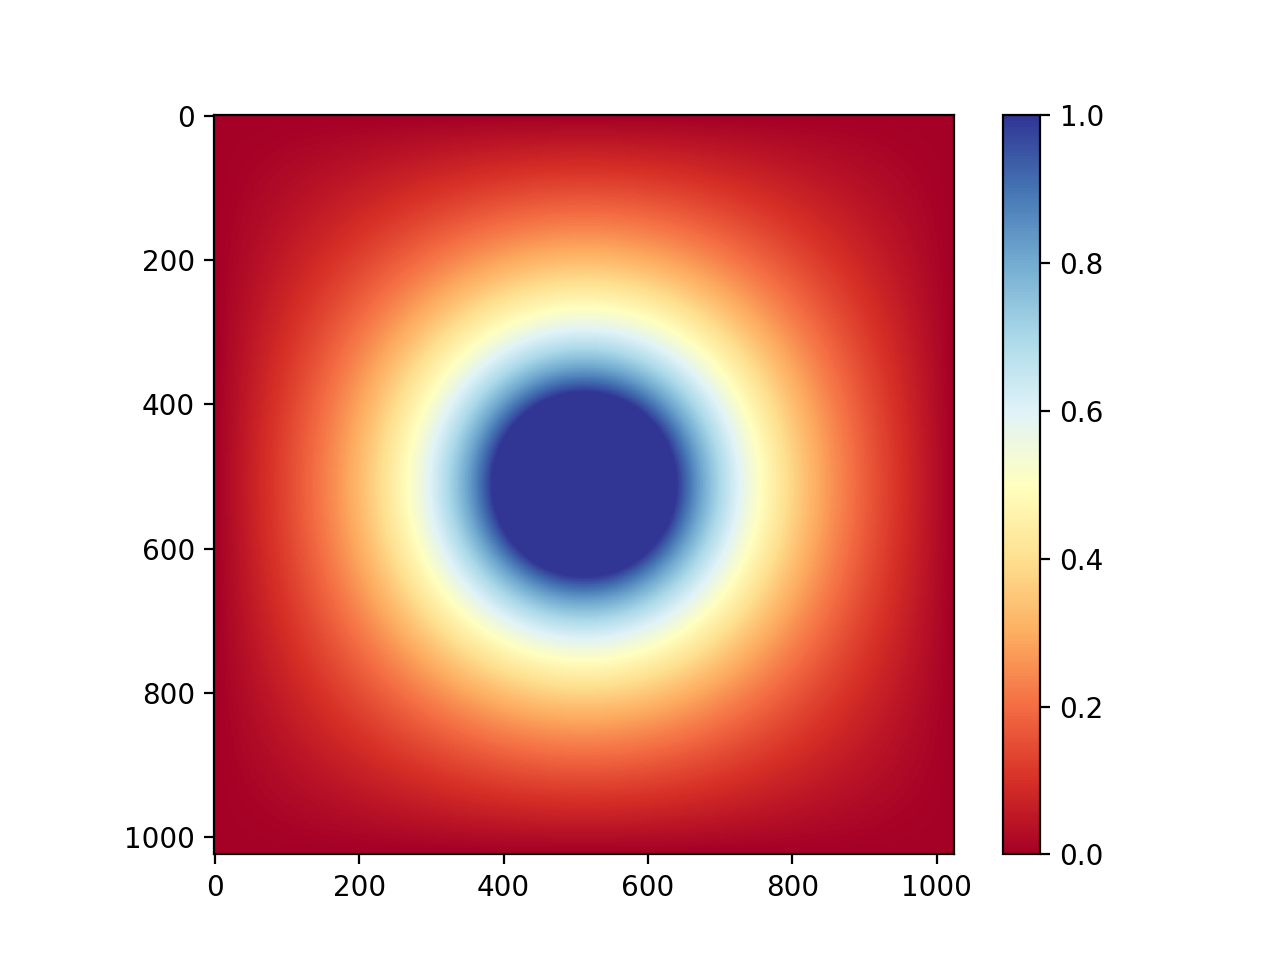

<IPython.core.display.Javascript object>


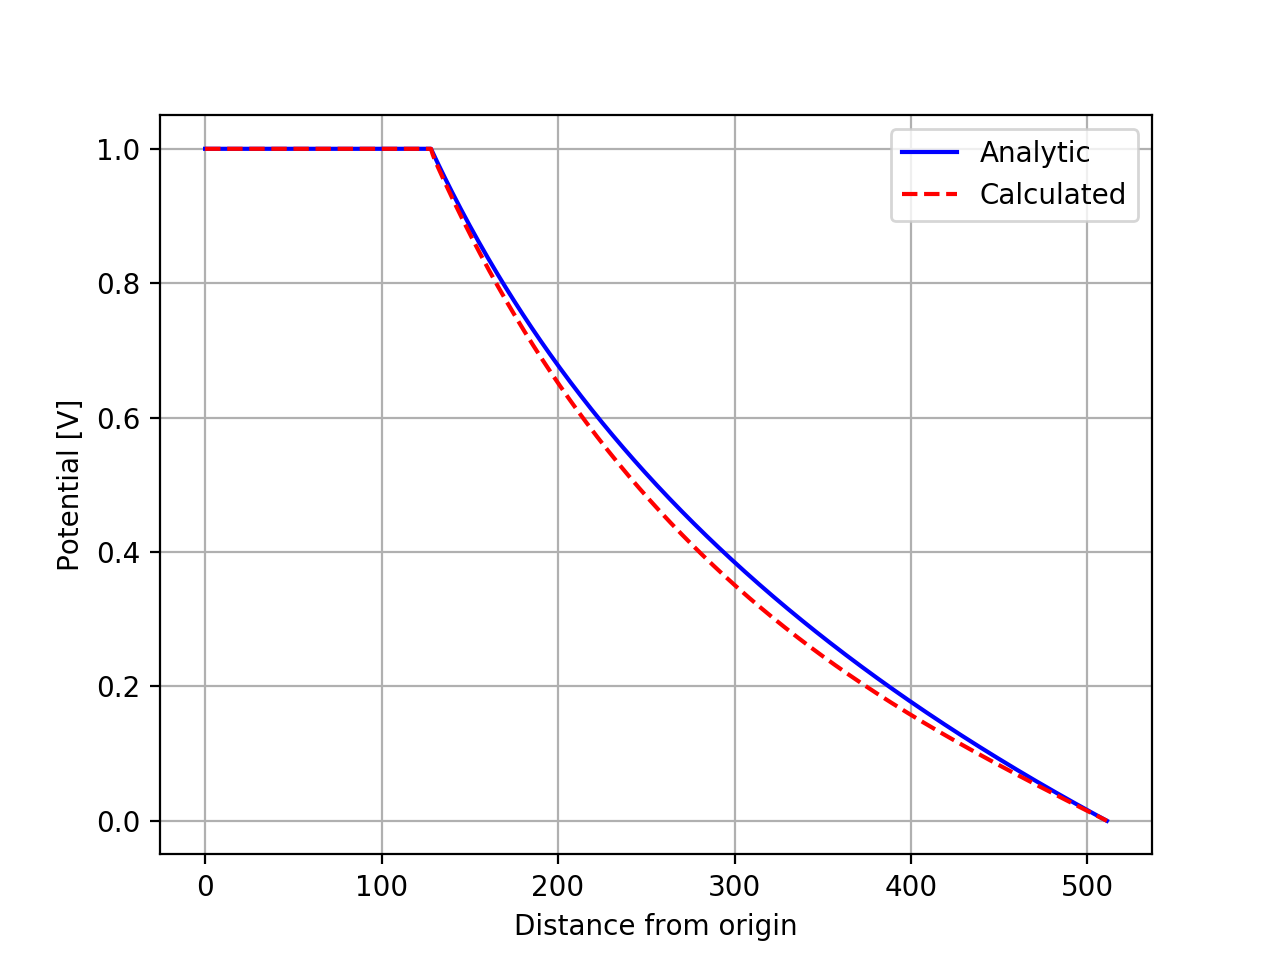

In [132]:
plot_solution(V,radius,npix,show_analytic=True,name="Problem 1")

## Conjugate Gradient and helper functions

In [59]:
def rhs_2d(pot,mask):
    mat = np.zeros(pot.shape)
    mat[:,:-1] = mat[:,:-1] + pot[:,1:]
    mat[:,1:]  = mat[:,1:]  + pot[:,:-1]
    mat[:-1,:] = mat[:-1,:] + pot[1:,:]
    mat[1:,:]  = mat[1:,:]  + pot[:-1,:]
    
    # Since the potential is constant in the mask regions, set it to zero for now.  
    mat[mask] = 0
    
    return mat

def ax_2d(mat,mask,copy=False):
    mat = mat.copy()
    #mat[mask] = 0
    
    mm = 4*mat
    
    mm[:,:-1] = mm[:,:-1] - mat[:,1:]
    mm[:,1:]  = mm[:,1:] - mat[:,:-1]
    mm[1:,:]  = mm[1:,:] - mat[:-1,:]
    mm[:-1,:] = mm[:-1,:] - mat[1:,:]
    
    # The boundary conditions as specified by the mask do not enter into the matrix since
    # they are handeled on the right-hand side of the matrix equation (in b).  
    mm[mask]  = 0
    
    return mm
    
def conjugate_gradient(rhs,x0,mask,tol = 1e-3):
    t1=time.time()
    Ax = ax_2d(x0,mask)
    r = rhs-Ax
    p = r.copy()
    x = x0.copy()
    rsqr = np.sum(r*r)
    convergence = 1
    i = 0 # counter
    while(convergence > tol):
        x_prev   = x
        Ap       = ax_2d(p,mask)
        alpha    = np.sum(r*r)/np.sum(Ap*p)
        x        = x+alpha*p
        convergence = np.max( np.abs(x-x_prev) )
        r        = r-alpha*Ap
        rsqr_new = np.sum(r*r)
        beta     = rsqr_new/rsqr
        p        = r+beta*p
        rsqr     = rsqr_new
        i += 1
        #print("Conjugate gradient convergence: %.2f %%\r"%((tol/convergence)*100), end = '')
            
    t2 = time.time()
    # Calculate time of execution
    t_execute = t2-t1
    return x,t_execute,i

In [60]:
# Functions to produce lower and higher resolution maps.
# Exactly those presented in laplace_2d_multi.py
def downconv_res(mat):
    mm = np.zeros([mat.shape[0]//2,mat.shape[1]//2],dtype=mat.dtype)
    mm = np.maximum(mm,mat[::2,::2])
    mm = np.maximum(mm,mat[::2,1::2])
    mm = np.maximum(mm,mat[1::2,::2])
    mm = np.maximum(mm,mat[1::2,1::2])
    return mm

def upconv_res(mat):
    mm = np.zeros([mat.shape[0]*2,mat.shape[1]*2],dtype=mat.dtype)
    mm[::2,::2]   = mat
    mm[::2,1::2]  = mat
    mm[1::2,::2]  = mat
    mm[1::2,1::2] = mat
    return mm

## Electric Field Calculator

In [61]:
def E_field(V):
    Ex = V[:,1:]-V[:,:-1]
    Ey = V[:-1,:]-V[1:,:]
    
    Ex = Ex[:-1,:]
    Ey = Ey[:,:-1]
    return Ex,Ey

$ $

# Problem 2

In [69]:
def part2_solver(mask,bc,tol = 1e-3):
    npix   = mask.shape[0]
    rhs    = rhs_2d(bc,mask)
    
    # Run the conjugate gradient algorithim
    V,time,ii = conjugate_gradient(rhs,0*rhs,mask,tol)
    print("Conjugate gradient algorithim completed in %.2f seconds or %d iterations."%(time,ii))
    # Put the boundary conditions into the soloution (since we didn't solve for them in conjugate gradient).
    V[mask] = bc[mask]
    # Calculate the charge distribution
    rho   = V # NOT DONE
    return V,rho

In [70]:
# We'll chose npix and the cylinder radius for a ratio npix/radius = 8
npix = 2**10; radius = 2**7;
print("Box size / Cylinder radius = ",npix/radius)
mask,bc,d = get_cylinder_mask(npix,radius,1,calc_dist=True)

Box size / Cylinder radius =  8.0
Making mask ...
Mask completed ...


In [71]:
V,rho = part2_solver(mask,bc,tol = 1e-6)

Conjugate gradient algorithim completed in 34.39 seconds or 1255 iterations.


<IPython.core.display.Javascript object>


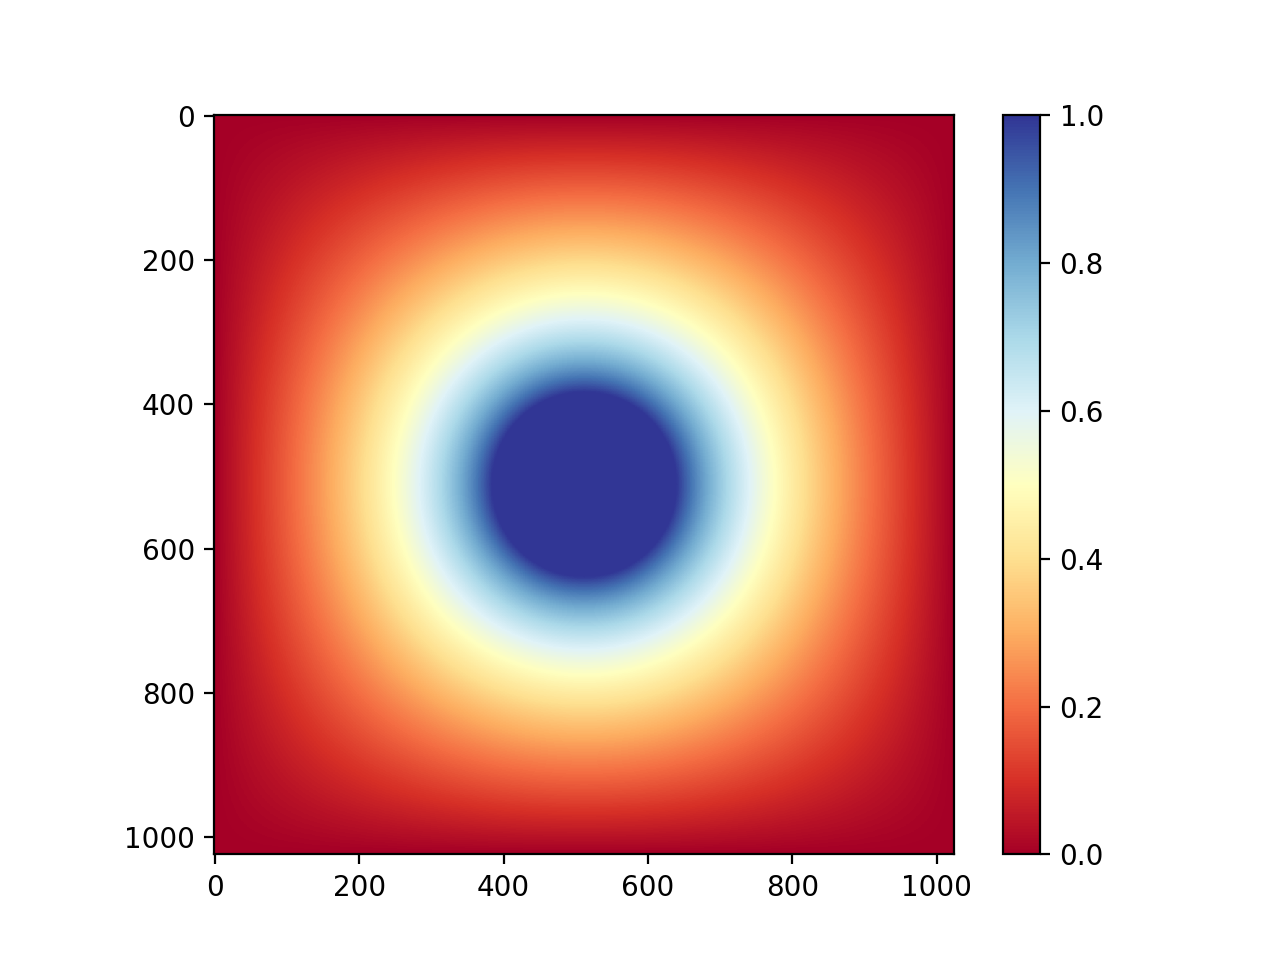

<IPython.core.display.Javascript object>


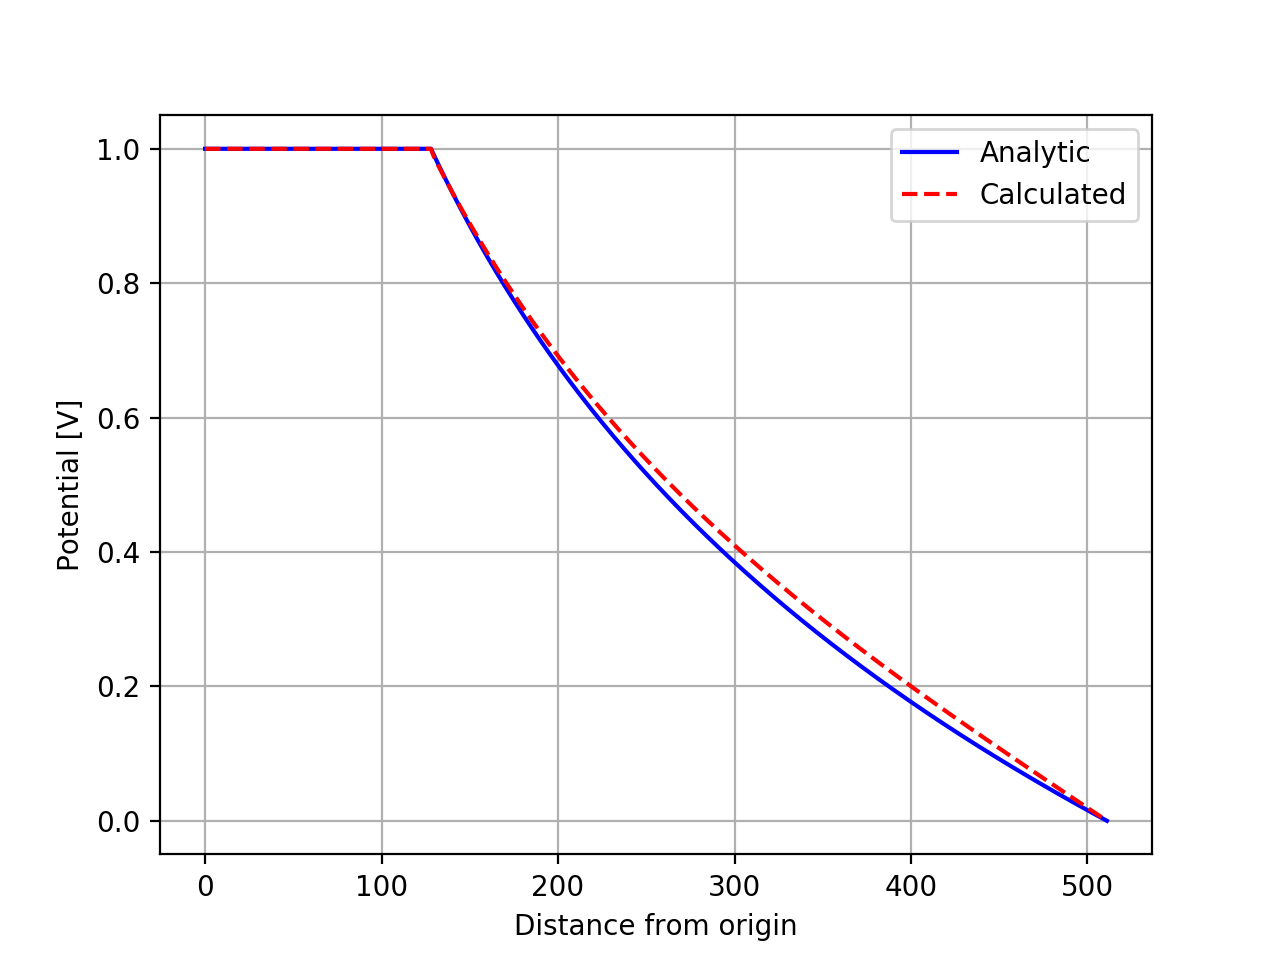

In [72]:
plot_solution(V,radius,npix,show_analytic=True,name="Problem 2")

$ $

# Problem 3

In [110]:
def part3_solver(mask,bc,tol = 1e-3,std = False):
    npix = mask.shape[0]
    # 
    n = int(np.log2(npix)) - 4

    all_masks = [None]*n
    all_bc    = [None]*n
    all_rhs   = [None]*n
    all_x     = [None]*n
    all_time  = [None]*n

    # Initialize all_masks and all_bc with the already calculated high resolution mask and boundary conditions.
    all_masks[0] = mask
    all_bc[0]    = bc

    # Calculate all the lower resolution masks and boundary conditions and assign them to all_masks and all_bc.
    print("Down-converting mask and boundary conditions ..")
    for i in range(1,n):
        all_masks[i] = downconv_res(all_masks[i-1])
        all_bc[i]    = downconv_res(all_bc[i-1])
    print("Running Conjugate gradient algorithim ..\n")
    
    # Make the lowest-resolution map using the low-res boundary conditions/mask we already made.
    all_rhs[-1]              = rhs_2d(all_bc[-1],all_masks[-1])
    all_x[-1],all_time[-1],ii   = conjugate_gradient(all_rhs[-1],0*all_rhs[-1],all_masks[-1],tol)
    print("%4d x %4d pixel resolution solution completed in %.4f seconds or %4d iterations"%(32,32,all_time[-1],ii))    
    
    for i in range(n-2,-1,-1):
        all_rhs[i] = rhs_2d(all_bc[i],all_masks[i])
        x0         = upconv_res(all_x[i+1])
        all_x[i],all_time[i],ii   = conjugate_gradient(all_rhs[i],x0,all_masks[i],tol)
        print("%4d x %4d pixel resolution solution completed in %.4f seconds or %4d iterations"%(2**(n-i+4),2**(n-i+4),all_time[i],ii))    
    
    print("\nTotal computation time = %.2f seconds."%sum(all_time))
    
    # Put the boundary conditions into the soloution.
    for i in range(n):
        all_x[i][all_masks[i]]=all_bc[i][all_masks[i]]

    V   = all_x[0]
    #print("Calculating charge distribution ..")
    rho = 4*V[1:-1,1:-1]- V[2:,1:-1]-V[:-2,1:-1]-V[1:-1,2:]-V[1:-1,:-2]
    print("Completed.")
    
    return V,rho

In [111]:
npix = 2**10; radius = 2**7;
print("Box size / Cylinder radius = ",npix/radius)
mask,bc,d = get_cylinder_mask(npix,radius,1,calc_dist=True)

Box size / Cylinder radius =  8.0
Making mask ...
Mask completed ...


In [112]:
V,rho = part3_solver(mask,bc,tol = 1e-6)

Down-converting mask and boundary conditions ..
Running Conjugate gradient algorithim ..

  32 x   32 pixel resolution solution completed in 0.0077 seconds or   58 iterations
  64 x   64 pixel resolution solution completed in 0.0159 seconds or  101 iterations
 128 x  128 pixel resolution solution completed in 0.0428 seconds or  177 iterations
 256 x  256 pixel resolution solution completed in 0.2417 seconds or  246 iterations
 512 x  512 pixel resolution solution completed in 1.9635 seconds or  434 iterations
1024 x 1024 pixel resolution solution completed in 12.7718 seconds or  442 iterations

Total computation time = 15.04 seconds.
Completed.


<IPython.core.display.Javascript object>


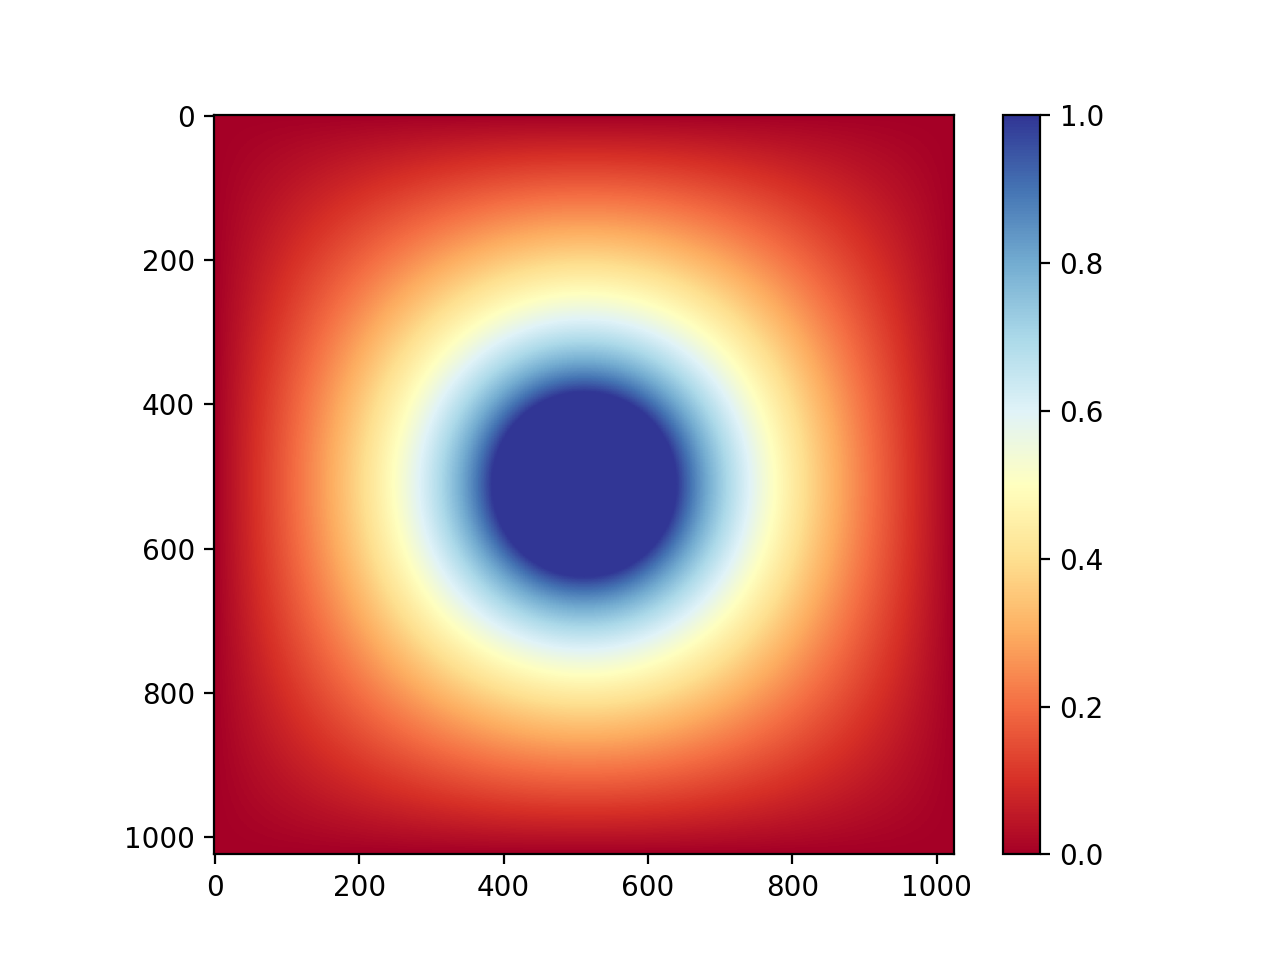

<IPython.core.display.Javascript object>


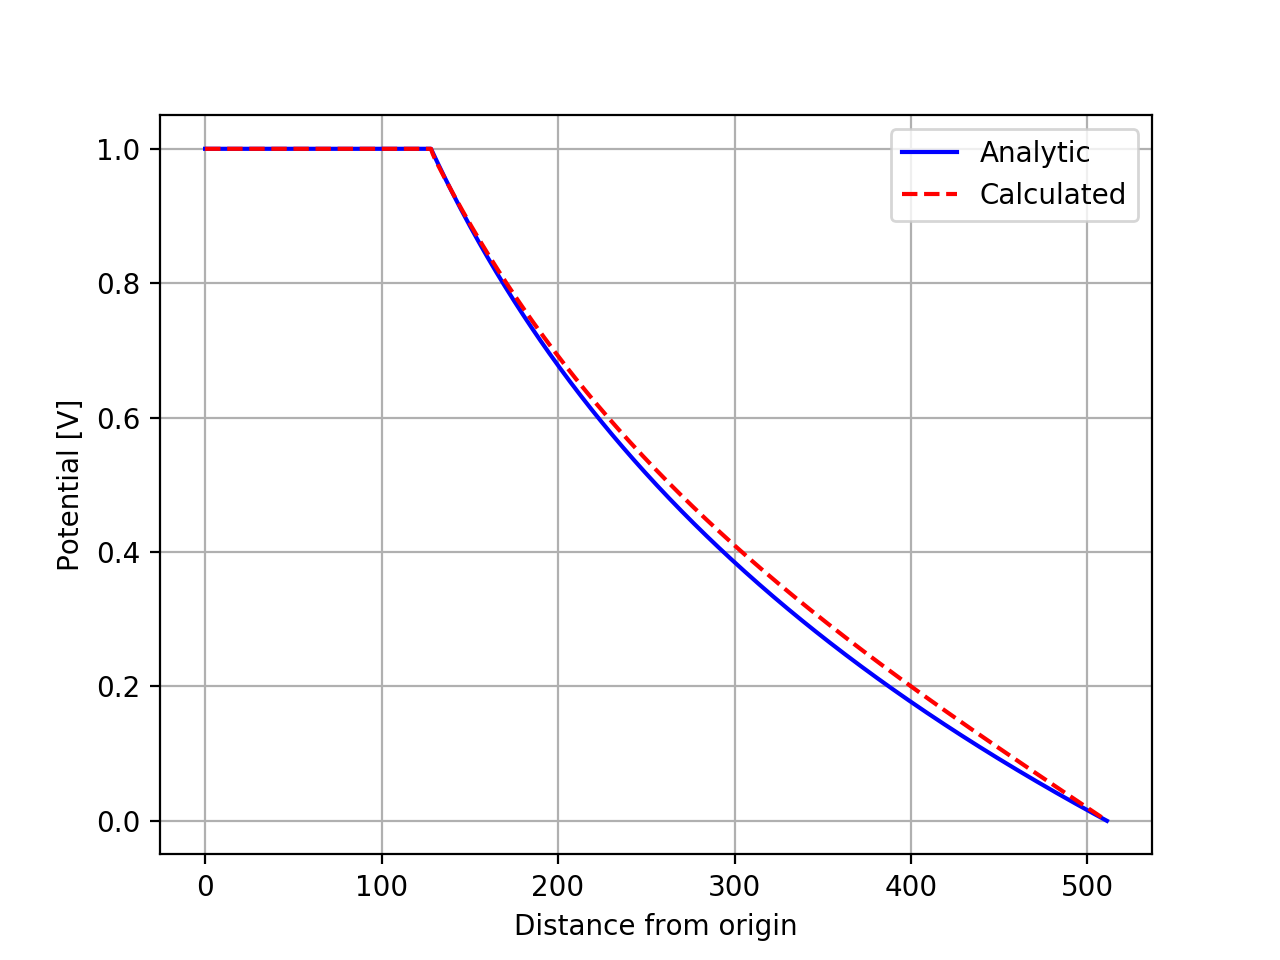

In [113]:
plot_solution(V,radius,npix,show_analytic=True,name = "Problem 3")

In [114]:
Ex,Ey =  E_field(V)
E_smooth_max = np.max(np.sqrt(Ex**2+Ey**2))
# Calculating the Electric field SPARSELY, so that we can draw an understandable vector plot!
d = 32 # Vector field sparsity
Ex_sparse = Ex[::d,::d]
Ey_sparse = Ey[::d,::d]
x = np.arange(0, npix//d, 1)
y = np.arange(0, npix//d, 1)
xx, yy = np.meshgrid(x, y)
xx,yy = d*xx,d*yy

<IPython.core.display.Javascript object>


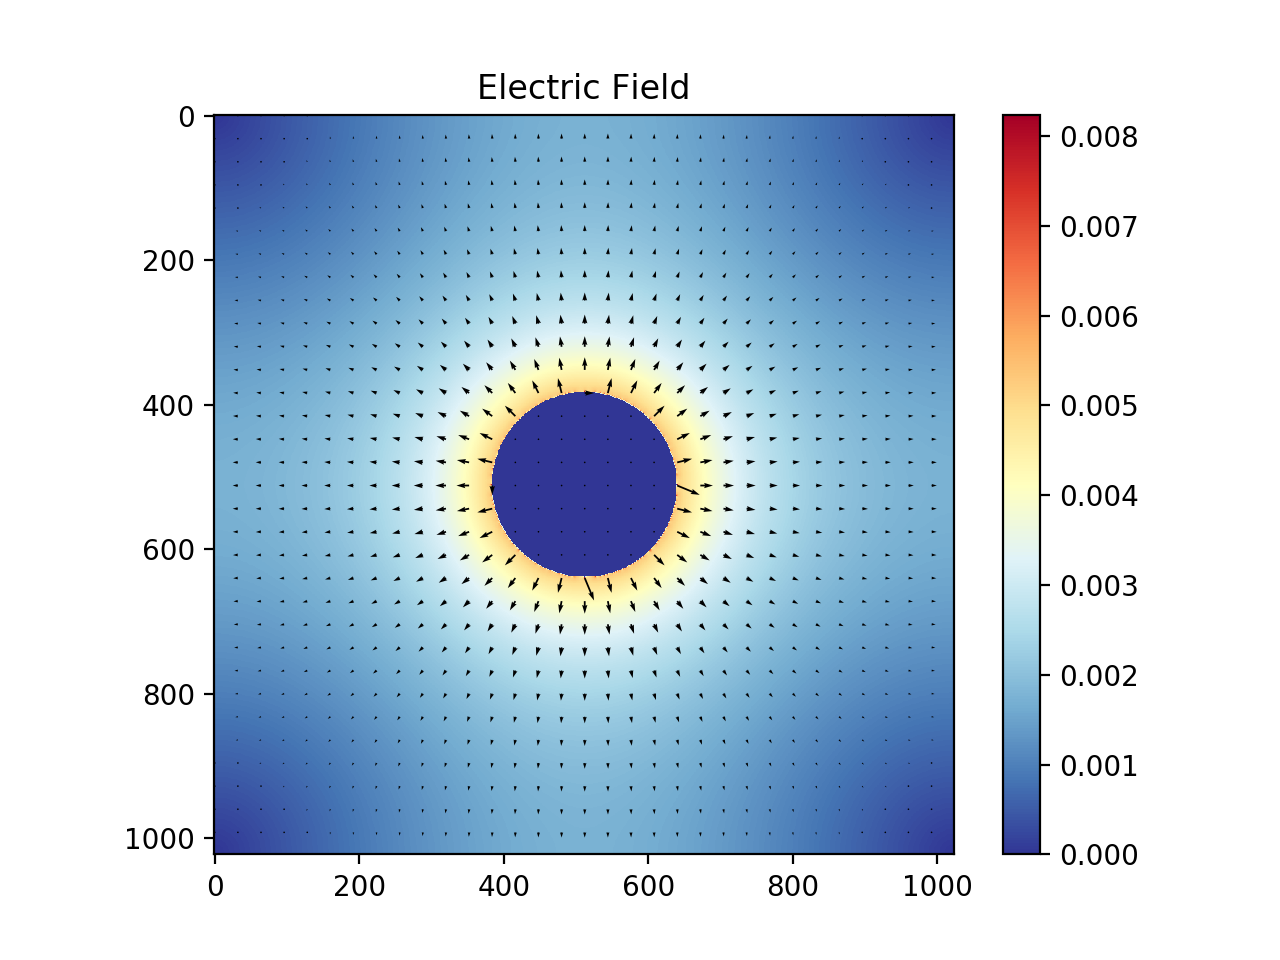

In [115]:
plt.figure()
plt.quiver(xx,yy,-Ex_sparse,-Ey_sparse,scale = 0.25)
plt.imshow(np.sqrt(Ex**2+Ey**2),cmap = E_cmap);plt.colorbar()
plt.title("Electric Field")
plt.show()
plt.savefig("Problem 3 Electric field direction and magnitude")

$ $

# Problem 4

In [118]:
# We'll chose npix and the cylinder radius for a ratio npix/radius = 8
npix = 2**11; radius = 2**8;
print("Box size / Cylinder radius = ",npix/radius)
mask,bc,d = get_cylinder_mask(npix,radius,1,calc_dist=True,perturb=True)

Box size / Cylinder radius =  8.0
Making mask ...
Mask completed ...


In [119]:
V,rho = part3_solver(mask,bc,tol = 1e-6)

Down-converting mask and boundary conditions ..
Running Conjugate gradient algorithim ..

  32 x   32 pixel resolution solution completed in 0.0034 seconds or   58 iterations
  64 x   64 pixel resolution solution completed in 0.0091 seconds or  102 iterations
 128 x  128 pixel resolution solution completed in 0.0412 seconds or  177 iterations
 256 x  256 pixel resolution solution completed in 0.2289 seconds or  247 iterations
 512 x  512 pixel resolution solution completed in 1.6909 seconds or  430 iterations
1024 x 1024 pixel resolution solution completed in 12.1783 seconds or  427 iterations
2048 x 2048 pixel resolution solution completed in 85.6114 seconds or  626 iterations

Total computation time = 99.76 seconds.
Completed.


<IPython.core.display.Javascript object>


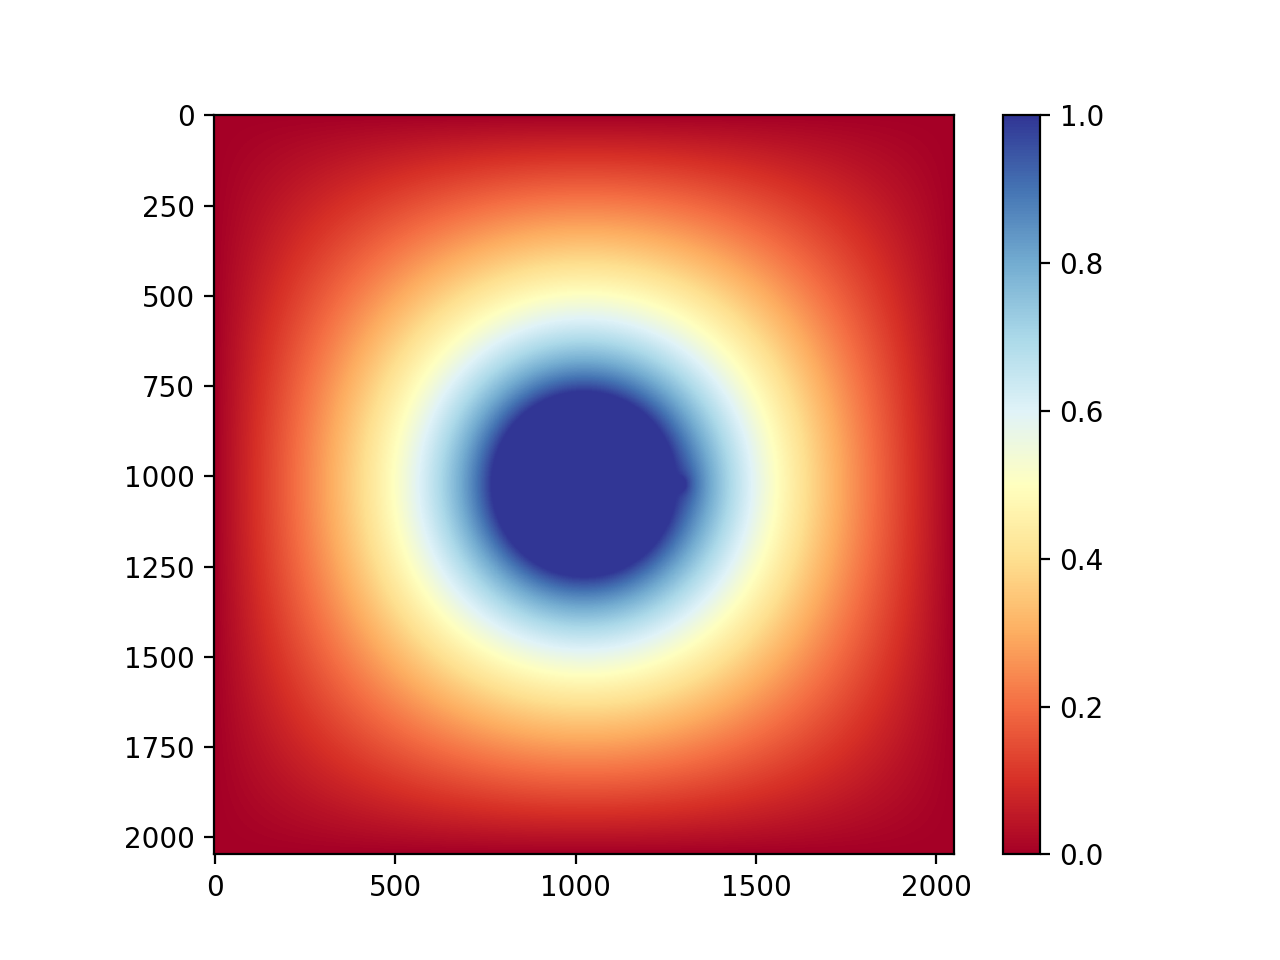

In [120]:
plot_solution(V,radius,npix,name = "Problem 4")

In [121]:
Ex,Ey = E_field(V)
E_pert_max = np.max(np.sqrt(Ex**2+Ey**2))
# Calculating the Electric field SPARSELY, so that we can draw an understandable vector plot!
vd = 64 # Vector field sparsity
Ex_sparse = Ex[::vd,::vd]
Ey_sparse = Ey[::vd,::vd]
x = np.arange(0, npix//vd, 1)
y = np.arange(0, npix//vd, 1)
xx, yy = np.meshgrid(x, y)
xx,yy = vd*xx,vd*yy

<IPython.core.display.Javascript object>


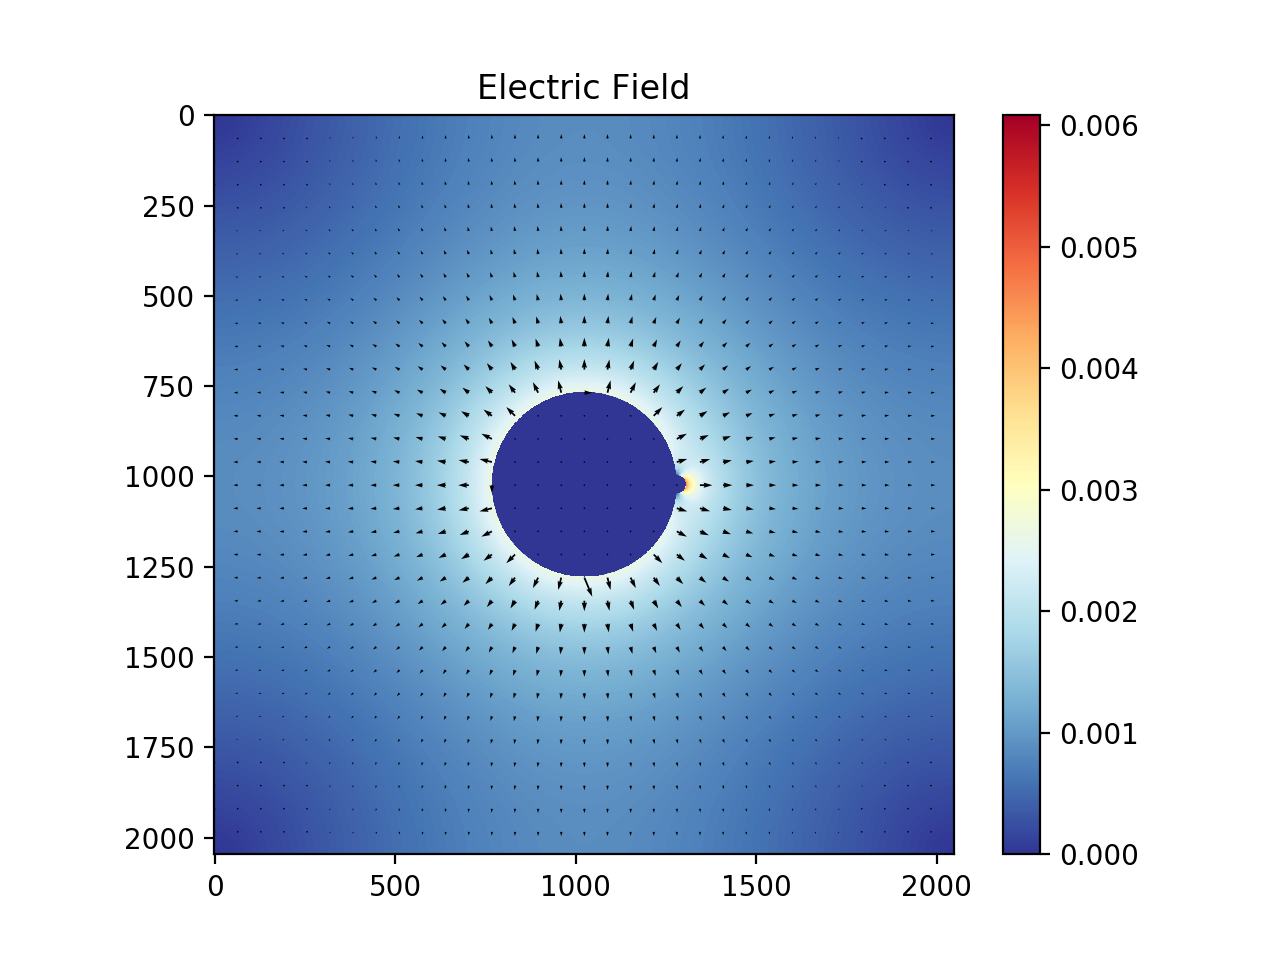

In [122]:
plt.figure()
plt.quiver(xx,yy,-Ex_sparse,-Ey_sparse,scale = 0.15)
plt.imshow(np.sqrt(Ex**2+Ey**2),cmap = E_cmap);plt.colorbar()
plt.title("Electric Field")
plt.show()
plt.savefig("Problem 4 Electric Field")

<IPython.core.display.Javascript object>


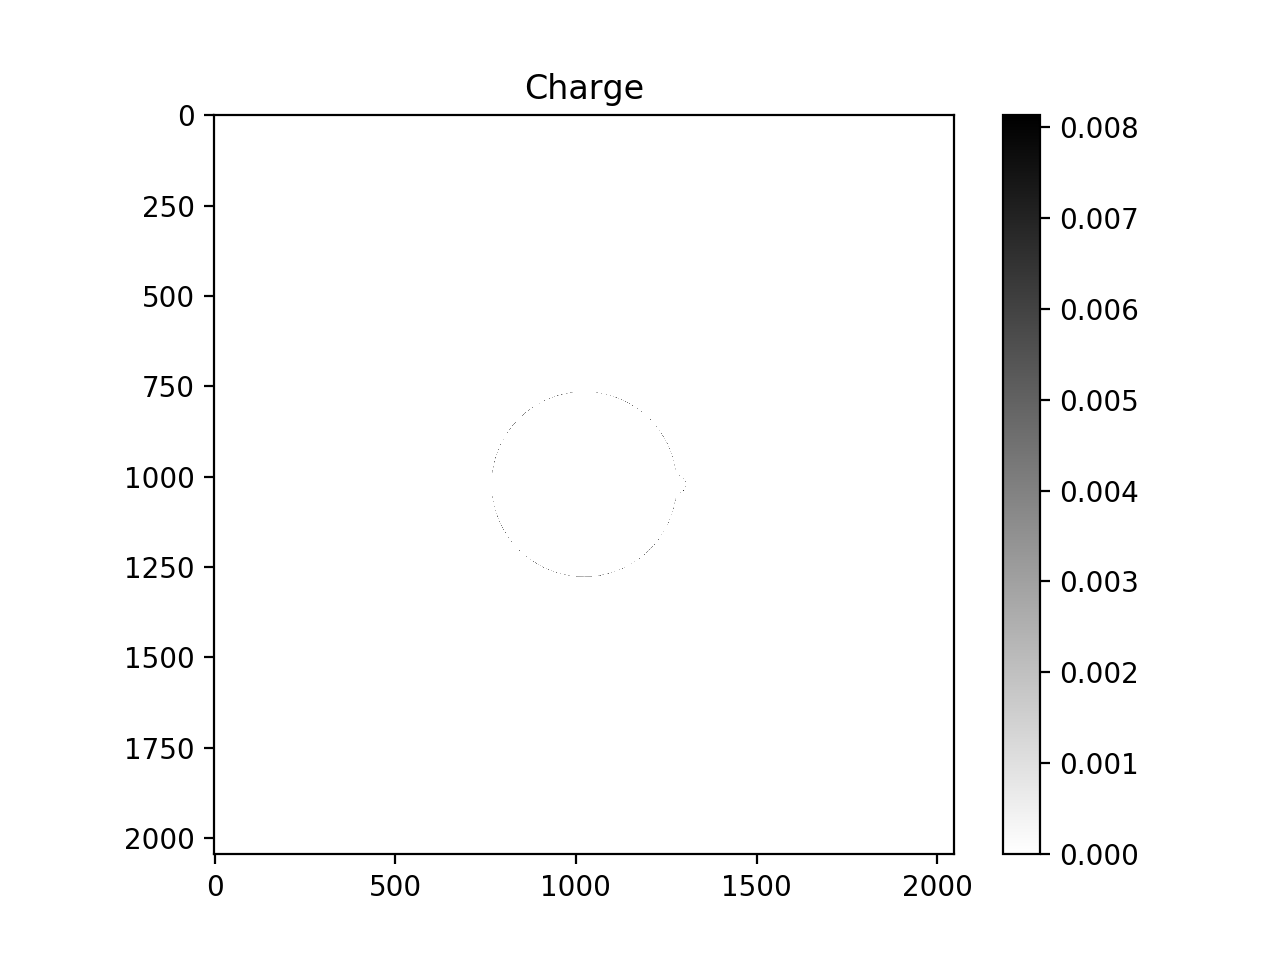

In [126]:
plt.figure()
plt.imshow(rho,cmap = 'binary');plt.colorbar()
plt.title("Charge")
plt.show()